### wls_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of a WLS estimator, as requested in the 3rd task, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

> In addition, at the end of file, there are also plots showing the actual position of the target and the anchors, and the estimated position of the target obtained from the execution of the WLS estimator.

In [11]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import pandas as pd
import numpy as np
import pprint
import math

In [12]:
def calculate_target_anchors_distance(anchor_dataframe):
	"""
	Calculates the distance between the target and the anchors using the Euclidean norm.
	This is the implementation of (1) on the reference paper.

	Parameters:
	anchor_dataframe (DataFrame): A DataFrame-object containing the dataset of one anchor.

	Returns:
	target_anchors_distance (list): Returns a list of distances between the target and the anchor.
	"""

	anchor_coords = [eval(i) for i in anchor_dataframe["Relative Coordinates [m]"][0].split(", ")]
	target_coords = [eval(i) for i in anchor_dataframe["Target Coordinates [m]"][0].split(", ")]
	target_anchors_distance = math.dist(anchor_coords, target_coords)

	return target_anchors_distance

# https://www.w3schools.com/python/ref_math_dist.asp
# https://www.w3schools.com/python/ref_string_split.asp
# https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/

In [13]:
def calculate_A_matrix(n_anchors, local_anchor_coords):
	'''
	Calculates the 'A' matrix of the system of equations which the WLS method solves.
	This is the implementation of (5) on the reference paper.

	Parameters:
	n_anchors (int) : An integer which value represents the number of anchors in dataset.
	local_anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.

	Returns:
	A (numpy.ndarray) : Returns a 2D numpy.ndarray which values are elements of the 'A' matrix for the selected scenario.
	'''

	# Build matrix A
	A = np.zeros((n_anchors, 3)) # 3 columns for -2x, -2y, 1

	for i in range(n_anchors):
		A[i, 0] = -2 * local_anchor_coords[i][0]
		A[i, 1] = -2 * local_anchor_coords[i][1]
		A[i, 2] = 1

	return A

In [14]:
def calculate_b_vector(n_anchors, local_anchor_coords, local_estimated_distances):
	'''
	Calculates the 'b' vector of the system of equations which the WLS method solves.
	This is the implementation of (5) on the reference paper.

	Parameters:
	n_anchors (int) : An integer which value represents the number of anchors in dataset.
	local_anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
	local_estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.

	Returns:
	b (numpy.ndarray): Returns a 1D numpy.ndarray which values are elements of the 'b' vector for the selected configuration.
	'''
	
	norm_coords = []
	b = []

	for i in range(n_anchors):
		sqr_distance = math.pow(local_estimated_distances[i], 2)
		norm_coords.append(np.linalg.norm(local_anchor_coords))
		sqr_coords = math.pow(norm_coords[i], 2)
		diff = sqr_distance - sqr_coords
		b.append(round(diff, 3))
		i = i + 1
	
	return np.array(b)

# https://www.digitalocean.com/community/tutorials/norm-of-vector-python
# https://numpy.org/doc/stable/reference/generated/numpy.append.html

In [15]:
def calculate_W_matrix(n_anchors, local_estimated_distances):
	"""
	Calculates, for the selected configuration, the 'W' diagonal matrix.
	The elements are the inverse of the variance of the square of the estimated distance.
	This is the implementation of [11, eq. (14)].

	Parameters:
	n_anchors (int) : An integer which value represents the number of anchors in dataset.
	local_estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.

	Returns:
	W (numpy.ndarray): Returns a 2D numpy.ndarray which values are elements of the 'W' diagonal matrix for the selected configuration.
	"""

	num = math.pow(constants.STANDARD_DEVIATION, 2)
	den = 4.715 * math.pow(constants.PATH_LOSS_EXPONENT, 2)
	exp_value = math.exp(num/den)
	var_inverse = []

	for i in range(n_anchors):
		e4_distance = math.pow(local_estimated_distances[i], 4)
		var = e4_distance * exp_value * (exp_value-1)
		var_inverse.append(round(math.pow(var, -1), 3))

	return np.diag(var_inverse)
	
# https://www.w3schools.com/python/ref_math_exp.asp
# https://numpy.org/doc/stable/reference/generated/numpy.diag.html

In [16]:
def calculate_WLS_output(A, W, b):
	"""
	Calculate the Weighted Least Squares (WLS) position estimate.
	This is the implementation of (6) on the reference paper.

	Parameters:
	A (numpy.ndarray): Matrix A.
	W (numpy.ndarray): Weight matrix W.
	b (numpy.ndarray): Vector b.

	Returns:
	position (numpy.ndarray): WLS position estimate.
	"""
	
	A_transpose = np.transpose(A)
	
	# Calculate (A^T * W * A)^(-1) * A^T * W * b
	left_term = np.linalg.inv(np.matmul(np.matmul(A_transpose, W), A))
	right_term = np.matmul(np.matmul(A_transpose, W), b)

	# Calculate the final result
	position = np.matmul(left_term, right_term)

	return position

# https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

In [17]:
def apply_WLS_estimator(scenario_name):
	'''
	Applies the WLS estimator in order to estimate the target's position
	from the anchors' position for the selected scenario.

	Parameters:
	scenario_name (str): The name of the scenario to be examined.

	Returns:
	data (dict):
	It is a dictionary containing all the salient information retrieved
	from the reading of the dataset (Actual) and from the application of the WLS estimator (Estimated),
	for all types of devices (Arduino, RPI) and for all technology (WiFi, BLT, Hybrid).
	'''
	
	dataset = auxfunc.define_dataset(scenario_name)

	for type in dataset[scenario_name]:

		dict = dataset[scenario_name][type]
		type_path = constants.DATASET_DIRECTORY + scenario_name + "/" + type + "/"

		for tech in dict:
			dataframes = []
			if tech != constants.HYBRID_TECHNOLOGY:
				for a in dict[tech]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + tech + "/" + a
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			else:
				# Concatenates the blt and wifi estimations
				for b in dict[constants.BLT_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.BLT_TECHNOLOGY + "/" + b
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))

				for w in dict[constants.WIFI_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.WIFI_TECHNOLOGY + "/" + w
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			
			dict[tech]["Actual"]["Dataframes"] = dataframes

		for tech in dict:
			dataframes = dict[tech]["Actual"]["Dataframes"]
			length = auxfunc.calculate_smallest_dataset(dataframes)
			burst_quantity = auxfunc.calculate_burst_quantity(length)
			n_anchors = len(dict[tech]["Actual"]["Anchors' Name"])

			# print(type, tech, length, burst_quantity, n_anchors, len(dataframes))

			dict[tech]["Actual"]["Distance Target - Anchor"] = []
			dict[tech]["Actual"]["Anchor Coordinates"] = []
			for a in range(n_anchors):
				dict[tech]["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
				dict[tech]["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
				dict[tech]["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

			for c in range(burst_quantity):
				dict[tech]["Estimated"][c] = {}
				dict[tech]["Estimated"][c]["Average RSS"] = []
				dict[tech]["Estimated"][c]["Distance Target - Anchor"] = []
				
				for a in range(n_anchors):
					average_RSS = auxfunc.calculate_average_RSS(dataframes[a]["Rx Power [dBm]"].to_list(), c, length)
					estimated_distance = auxfunc.calculate_target_anchor_estimation(average_RSS)
					dict[tech]["Estimated"][c]["Average RSS"].append(average_RSS)
					dict[tech]["Estimated"][c]["Distance Target - Anchor"].append(estimated_distance)

				A_mat = calculate_A_matrix(n_anchors, dict[tech]["Actual"]["Anchor Coordinates"])
				B_vet = calculate_b_vector(n_anchors, dict[tech]["Actual"]["Anchor Coordinates"], dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				W_mat = calculate_W_matrix(n_anchors, dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				
				dict[tech]["Estimated"][c]["A matrix"] = A_mat
				dict[tech]["Estimated"][c]["b vector"] = B_vet
				dict[tech]["Estimated"][c]["W matrix"] = W_mat
				dict[tech]["Estimated"][c]["Target Coordinates"] = calculate_WLS_output(A_mat, W_mat, B_vet)[[0,1]]
			
			dataset[scenario_name][type][tech] = dict[tech]

	return dataset
	
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

In [18]:
data = {}
data.update(apply_WLS_estimator("Scenario A"))
data.update(apply_WLS_estimator("Scenario B"))
data.update(apply_WLS_estimator("Scenario C"))

# np.set_printoptions(suppress=True)
# pprint.pprint(data)
# for configuration in data["Scenario A"]["RPI"]["RSS_BLT_Dataset"]["Estimated"].values():
#     pprint.pprint(configuration["Target Coordinates"])

In [19]:
for scenario in data:
    print("RMSE per", scenario)
    for type in data[scenario]:
        for tech in data[scenario][type]:
            print(type + "_" + tech + ":", auxfunc.calculate_rmse(data[scenario][type][tech]), "m")
    print()

RMSE per Scenario A
RPI_RSS_BLT_Dataset: 0.847 m
RPI_RSS_WiFi_Dataset: 0.106 m
RPI_RSS_Hybrid_Dataset: 0.129 m
Arduino_RSS_WiFi_Dataset_5dbm: 0.618 m
Arduino_RSS_WiFi_Dataset_0dbm: 0.513 m
Arduino_RSS_WiFi_Dataset_15dbm: 0.279 m
Arduino_RSS_WiFi_Dataset_10dbm: 0.803 m
Arduino_RSS_WiFi_Dataset_20dbm: 0.143 m

RMSE per Scenario B
RPI_RSS_BLT_Dataset: 5.15 m
RPI_RSS_WiFi_Dataset: 4.854 m
RPI_RSS_Hybrid_Dataset: 4.881 m

RMSE per Scenario C
RPI_RSS_BLT_Dataset: 0.913 m
RPI_RSS_WiFi_Dataset: 0.084 m
RPI_RSS_Hybrid_Dataset: 0.095 m



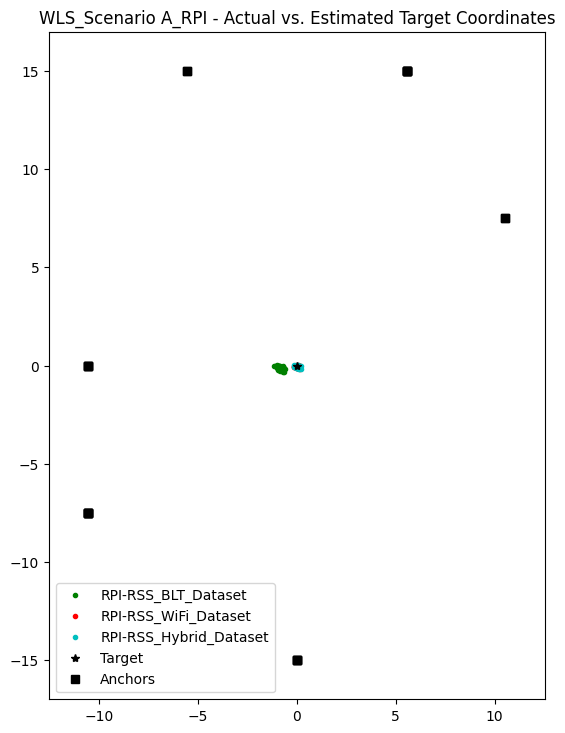

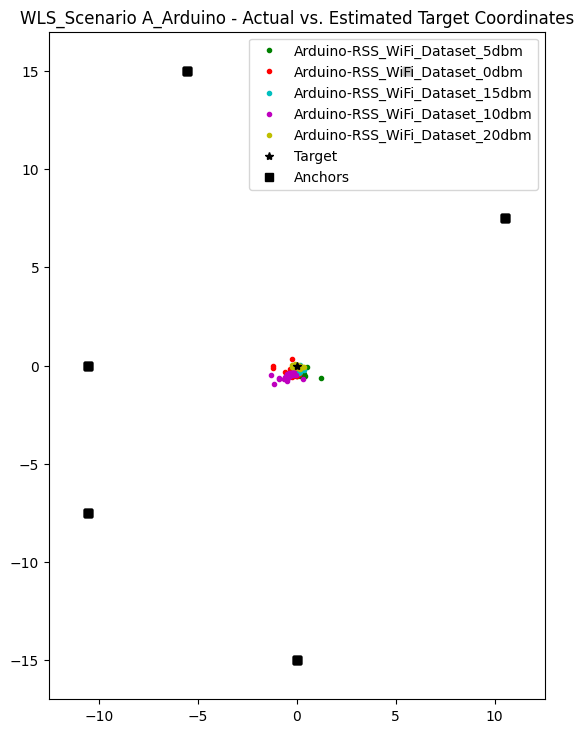

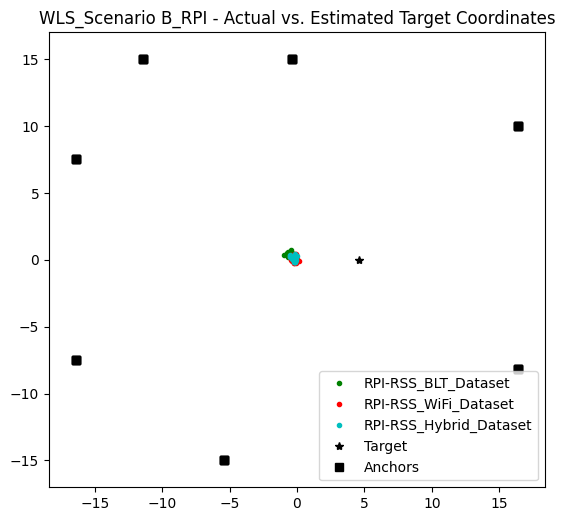

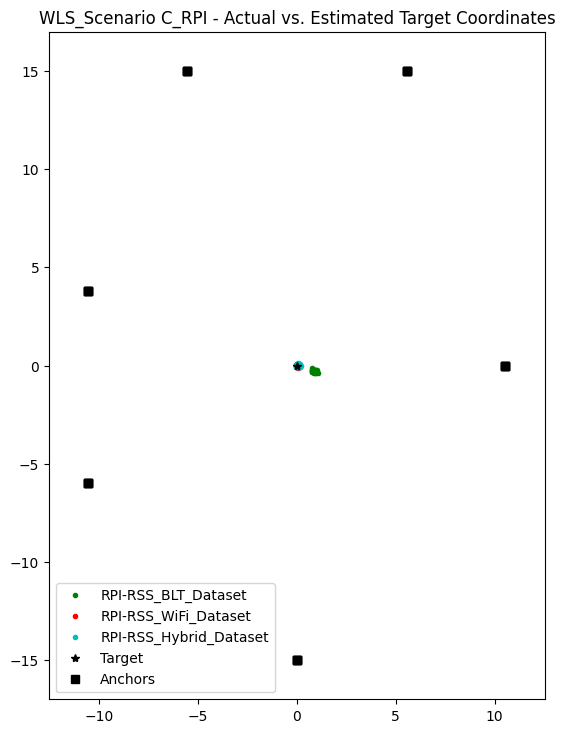

In [20]:
auxfunc.plot_data("WLS", data)